In [66]:
TICKER = "ETHUSDC"
STOP_DATE = pd.Timestamp(year=2025, month=1, day=1, hour=12)
LONGEST_PERIOD_MONTHS = 12
NUM_FOLDS = 4 # note: this will test NUM_FOLDS-1 times
MIN_LOOKBACK = 5
MAX_LOOKBACK = 20
NUM_FEATURES = 10

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

SAVE_CSV = TICKER + "_results.csv"
SAVE_MODEL = TICKER + "_model.h5"

# optuna hyperparams
def HYPERPARAMS(funct, **kwargs):
    def objective(trial):
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
        batch_size = trial.suggest_int("batch_size", 16, 128)
        epochs = trial.suggest_int("epochs", 10, 50)
        activation = trial.suggest_categorical("activation", ["relu", "tanh"])
        lstm_units = trial.suggest_int("lstm_units", 32, 128)
        lookback = trial.suggest_int("lookback", MIN_LOOKBACK, MAX_LOOKBACK)
        
        hyperparams = {
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs,
            'lstm_units': lstm_units,
            'activation': activation,
            'lookback': lookback,
        }
        return funct(hyperparams=hyperparams, **kwargs)
    return objective


def appendResult(hyperparams=None, scores=None):
    if not scores:
        open(SAVE_CSV, "w").close()
        return
    with open(SAVE_CSV, "a") as f:
        if f.tell() == 0:
            f.write(",".join([*hyperparams.keys(), *scores.keys()]) + "\n")
        f.write(",".join(str(i) for i in [*hyperparams.values(), *scores.values()]) + "\n")

In [68]:
def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)


# Okay, but seriously there's a big problem

The LSTM is trained on min-max scaled data from 2024-2025.

But when we do the RL, the min-max scaling happens from 2025-present.

So the min-max scaling isn't even the same.

In [69]:
def a(x):
    a.b = 5
    def updateB():
        a.b = 10

    updateB()

    return x + a.b
a(5)

15

In [70]:
"""
=== Q&A ===

RL Model
[      Train      ] [  Test  ]
[  Train  ]  [Test]
LSTM Model


Q: Will this program only have access to "train" data? Should it have access to "test" data?
A: It should not have access to "test" data. If we want to see how it performs on test data,
we run a separate experiment from "training". Even automated performance monitoring on the
"test" data will be conducted globally, not locally.

Q: How will this program optimize the LSTM model before handing it off?
Step 1: generate Walk-Forward Test Folds (A test B, AB test C, ABC test D, ... A-Y test Z)
Step 2: use optuna to find the hyperparameters that have the best average MSE
Step 3: train those hyperparameters on A-Z, publish

Q: What financial indicators? What target?
A: No financial indicators
   Predicts "Open"

"""


from sklearn import preprocessing
def getAssetData(ticker, maxPeriodLength_months=12):
    df = pd.read_csv(f'assets/{ticker}.csv')

    # filter to longest contiguous before STOP_DATE
    df.drop(columns=["Ignore", "Close time"], inplace=True)
    df["Open time"] = df["Open time"].apply(lambda x: x * 1000 if len(str(x)) < len("1738369800000000") else x)
    df["Open time"] = pd.to_datetime(df["Open time"], unit='us')
    df.set_index("Open time", inplace=True)
    df.sort_index(inplace=True)

    df = df[df.index < STOP_DATE]

    df["Gap"] = df.index.to_series().diff().dt.total_seconds().div(60).fillna(0)
    valid_intervals = df[df["Gap"] <= 30]
    last_gap_index = df[df["Gap"] > 30].index[-1]
    df = df.loc[last_gap_index:]
    

    df.drop(columns=["Gap"], inplace=True)

    # add financial indicators

    # chop off N/A or longer than maxPeriodLength
    df.dropna(inplace=True)
    df = df[df.index > (df.index[-1] - pd.DateOffset(months=maxPeriodLength_months))]

    # normalize except the target
    target = df["Open"].copy()
    scaler = preprocessing.MinMaxScaler()
    normalized_columns = scaler.fit_transform(df)
    df = pd.DataFrame(normalized_columns, columns=df.columns, index=df.index)
    df["Target"] = target

    return df

def formatLSTMInput(df, numFolds=4, lookback=5):
    foldEndIndices = [int(len(df) * (i + 1) / numFolds) for i in range(numFolds)]
    foldEndIndices = [0] + foldEndIndices + [len(df)]

    folds = [df.iloc[foldEndIndices[i]:foldEndIndices[i + 1]] for i in range(len(foldEndIndices) - 1)]
    folds = [fold.reset_index(drop=True) for fold in folds]

    def formatXy(fold):
        if len(fold) <= lookback:
            print("Your fold is smaller than the lookback+1 period, so bro, fix it, please")
            return None, None
        X = pd.concat([fold.shift(i) for i in range(lookback, 0, -1)], axis=1).dropna()
        X = np.reshape(X.values, (len(X), lookback, len(fold.columns)))
        y = np.reshape(fold["Target"].shift(-lookback).dropna(), (-1, 1))
        return X, y

    # format X and format Y
    trainTestFolds = []
    for i in range(len(folds)-2):
        train_fold = pd.concat(folds[0:i + 1], axis=0)
        test_fold = folds[i + 1]
        X_train, y_train = formatXy(train_fold)
        X_test, y_test = formatXy(test_fold)
        trainTestFolds.append({
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test
        })
    
    train_final = pd.concat(folds, axis=0)
    X_final, y_final = formatXy(train_final)
    finalData = {
        'X_train': X_final,
        'y_train': y_final,
    }

    return { 'train-test-folds': trainTestFolds, 'final-train': finalData }

def generateModel(hyperparams):
    # build the Keras sequential model
    learning_rate = hyperparams.get('learning_rate', 0.001)
    batch_size = hyperparams.get('batch_size', 32)
    epochs = hyperparams.get('epochs', 20)
    lstm_units = hyperparams.get('lstm_units', 50)
    activation = hyperparams.get('activation', 'relu')
    lookback = hyperparams.get('lookback', 5)
    input_shape = hyperparams.get('input_shape', (lookback, NUM_FEATURES))

    model = Sequential([
        LSTM(lstm_units, activation='relu', input_shape=input_shape),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def KFoldsTrainTest(hyperparams, data):
    inputs = formatLSTMInput(data, numFolds=NUM_FOLDS, lookback=hyperparams['lookback'])
    trainTestFolds = inputs['train-test-folds']

    hyperparams = hyperparams.copy()
    hyperparams['input_shape'] = trainTestFolds[0]['X_train'].shape[1:]

    print(f"Hyperparameters: {hyperparams}")
    print("Shape: ", trainTestFolds[0]['X_train'].shape)

    # train the model on each fold and evaluate
    mse_scores = []
    for fold in trainTestFolds:
        model = generateModel(hyperparams)
        X_train, y_train = fold['X_train'], fold['y_train']
        X_test, y_test = fold['X_test'], fold['y_test']

        # fit the model
        model.fit(X_train, y_train, epochs=hyperparams['epochs'], batch_size=hyperparams['batch_size'], verbose=0)

        # evaluate the model
        mse = model.evaluate(X_test, y_test, verbose=0)
        mse_scores.append(mse)

    # return the average MSE
    appendResult(hyperparams, { 'mse_scores': ";".join(str(i) for i in mse_scores) })
    return np.mean(mse_scores)

def getOptimalModel(saveAs):
    appendResult()

    data = getAssetData(TICKER, LONGEST_PERIOD_MONTHS)
    

    objective = HYPERPARAMS(KFoldsTrainTest, data=data)
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)
    bestHyperparams = study.best_trial.params

    finalData = formatLSTMInput(data, NUM_FOLDS, bestHyperparams['lookback'])['final-train']

    model = generateModel(bestHyperparams)
    model.fit(finalData['X_train'], finalData['y_train'], epochs=bestHyperparams['epochs'], batch_size=bestHyperparams['batch_size'], verbose=1)
    model.save(saveAs)
    print(f"Best hyperparameters: {bestHyperparams}")


    # Predict on the training data
    predictions = model.predict(finalData['X_train'])

    # Calculate errors
    errors = predictions.flatten() - finalData['y_train'].flatten()

    # Plot error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(range(len(errors)), predictions.flatten(), yerr=abs(errors), ecolor='red', label='Prediction with Error Bars')
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Value')
    plt.title('Prediction Error Bars')
    plt.legend()
    plt.show()

    return { 'model': model, 'hyperparams': bestHyperparams }

[I 2025-03-29 14:39:23,754] A new study created in memory with name: no-name-88d9c036-fc75-4d7b-aa08-bfd423669ac3
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 3.257812484689629e-05, 'batch_size': 55, 'epochs': 11, 'lstm_units': 120, 'activation': 'relu', 'lookback': 8, 'input_shape': (8, 10)}
Shape:  (4384, 8, 10)


[I 2025-03-29 14:39:42,103] Trial 0 finished with value: 823.9991251627604 and parameters: {'learning_rate': 3.257812484689629e-05, 'batch_size': 55, 'epochs': 11, 'activation': 'relu', 'lstm_units': 120, 'lookback': 8}. Best is trial 0 with value: 823.9991251627604.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.00048347717241872904, 'batch_size': 104, 'epochs': 11, 'lstm_units': 82, 'activation': 'tanh', 'lookback': 19, 'input_shape': (19, 10)}
Shape:  (4373, 19, 10)


[I 2025-03-29 14:39:59,657] Trial 1 finished with value: 1205.3614501953125 and parameters: {'learning_rate': 0.00048347717241872904, 'batch_size': 104, 'epochs': 11, 'activation': 'tanh', 'lstm_units': 82, 'lookback': 19}. Best is trial 0 with value: 823.9991251627604.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.00019374877111806913, 'batch_size': 72, 'epochs': 38, 'lstm_units': 32, 'activation': 'tanh', 'lookback': 19, 'input_shape': (19, 10)}
Shape:  (4373, 19, 10)


[I 2025-03-29 14:40:43,431] Trial 2 finished with value: 1146.3588053385417 and parameters: {'learning_rate': 0.00019374877111806913, 'batch_size': 72, 'epochs': 38, 'activation': 'tanh', 'lstm_units': 32, 'lookback': 19}. Best is trial 0 with value: 823.9991251627604.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.007672991512615836, 'batch_size': 63, 'epochs': 10, 'lstm_units': 65, 'activation': 'relu', 'lookback': 15, 'input_shape': (15, 10)}
Shape:  (4377, 15, 10)


[I 2025-03-29 14:40:59,614] Trial 3 finished with value: 1671.2621663411458 and parameters: {'learning_rate': 0.007672991512615836, 'batch_size': 63, 'epochs': 10, 'activation': 'relu', 'lstm_units': 65, 'lookback': 15}. Best is trial 0 with value: 823.9991251627604.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.0033428051597805043, 'batch_size': 53, 'epochs': 35, 'lstm_units': 74, 'activation': 'tanh', 'lookback': 11, 'input_shape': (11, 10)}
Shape:  (4381, 11, 10)


[I 2025-03-29 14:41:44,880] Trial 4 finished with value: 1260.9362182617188 and parameters: {'learning_rate': 0.0033428051597805043, 'batch_size': 53, 'epochs': 35, 'activation': 'tanh', 'lstm_units': 74, 'lookback': 11}. Best is trial 0 with value: 823.9991251627604.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 2.159160592357428e-05, 'batch_size': 98, 'epochs': 20, 'lstm_units': 88, 'activation': 'tanh', 'lookback': 11, 'input_shape': (11, 10)}
Shape:  (4381, 11, 10)


[I 2025-03-29 14:42:09,563] Trial 5 finished with value: 879.0972493489584 and parameters: {'learning_rate': 2.159160592357428e-05, 'batch_size': 98, 'epochs': 20, 'activation': 'tanh', 'lstm_units': 88, 'lookback': 11}. Best is trial 0 with value: 823.9991251627604.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.00015640103447093088, 'batch_size': 116, 'epochs': 27, 'lstm_units': 109, 'activation': 'tanh', 'lookback': 13, 'input_shape': (13, 10)}
Shape:  (4379, 13, 10)


[I 2025-03-29 14:42:48,085] Trial 6 finished with value: 1249.2117309570312 and parameters: {'learning_rate': 0.00015640103447093088, 'batch_size': 116, 'epochs': 27, 'activation': 'tanh', 'lstm_units': 109, 'lookback': 13}. Best is trial 0 with value: 823.9991251627604.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 4.4885353484050625e-05, 'batch_size': 118, 'epochs': 43, 'lstm_units': 80, 'activation': 'tanh', 'lookback': 17, 'input_shape': (17, 10)}
Shape:  (4375, 17, 10)


[I 2025-03-29 14:43:44,273] Trial 7 finished with value: 1494.7747802734375 and parameters: {'learning_rate': 4.4885353484050625e-05, 'batch_size': 118, 'epochs': 43, 'activation': 'tanh', 'lstm_units': 80, 'lookback': 17}. Best is trial 0 with value: 823.9991251627604.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 7.040327641953431e-05, 'batch_size': 76, 'epochs': 26, 'lstm_units': 106, 'activation': 'relu', 'lookback': 12, 'input_shape': (12, 10)}
Shape:  (4380, 12, 10)


[I 2025-03-29 14:44:30,919] Trial 8 finished with value: 1352.941650390625 and parameters: {'learning_rate': 7.040327641953431e-05, 'batch_size': 76, 'epochs': 26, 'activation': 'relu', 'lstm_units': 106, 'lookback': 12}. Best is trial 0 with value: 823.9991251627604.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.0004455207517698801, 'batch_size': 68, 'epochs': 12, 'lstm_units': 55, 'activation': 'tanh', 'lookback': 17, 'input_shape': (17, 10)}
Shape:  (4375, 17, 10)


[I 2025-03-29 14:44:48,605] Trial 9 finished with value: 3074.2135009765625 and parameters: {'learning_rate': 0.0004455207517698801, 'batch_size': 68, 'epochs': 12, 'activation': 'tanh', 'lstm_units': 55, 'lookback': 17}. Best is trial 0 with value: 823.9991251627604.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 1.267449396186219e-05, 'batch_size': 21, 'epochs': 19, 'lstm_units': 128, 'activation': 'relu', 'lookback': 6, 'input_shape': (6, 10)}
Shape:  (4386, 6, 10)


[I 2025-03-29 14:45:32,118] Trial 10 finished with value: 752.5320027669271 and parameters: {'learning_rate': 1.267449396186219e-05, 'batch_size': 21, 'epochs': 19, 'activation': 'relu', 'lstm_units': 128, 'lookback': 6}. Best is trial 10 with value: 752.5320027669271.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 1.2844007596025787e-05, 'batch_size': 17, 'epochs': 19, 'lstm_units': 125, 'activation': 'relu', 'lookback': 5, 'input_shape': (5, 10)}
Shape:  (4387, 5, 10)


[I 2025-03-29 14:46:18,822] Trial 11 finished with value: 706.5919392903646 and parameters: {'learning_rate': 1.2844007596025787e-05, 'batch_size': 17, 'epochs': 19, 'activation': 'relu', 'lstm_units': 125, 'lookback': 5}. Best is trial 11 with value: 706.5919392903646.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 1.2048596644630153e-05, 'batch_size': 16, 'epochs': 22, 'lstm_units': 126, 'activation': 'relu', 'lookback': 6, 'input_shape': (6, 10)}
Shape:  (4386, 6, 10)


[I 2025-03-29 14:47:18,726] Trial 12 finished with value: 1322.833760579427 and parameters: {'learning_rate': 1.2048596644630153e-05, 'batch_size': 16, 'epochs': 22, 'activation': 'relu', 'lstm_units': 126, 'lookback': 6}. Best is trial 11 with value: 706.5919392903646.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 1.1254986449284801e-05, 'batch_size': 16, 'epochs': 17, 'lstm_units': 101, 'activation': 'relu', 'lookback': 5, 'input_shape': (5, 10)}
Shape:  (4387, 5, 10)


[I 2025-03-29 14:47:56,819] Trial 13 finished with value: 715.9677124023438 and parameters: {'learning_rate': 1.1254986449284801e-05, 'batch_size': 16, 'epochs': 17, 'activation': 'relu', 'lstm_units': 101, 'lookback': 5}. Best is trial 11 with value: 706.5919392903646.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.0014172404403670485, 'batch_size': 30, 'epochs': 19, 'lstm_units': 102, 'activation': 'relu', 'lookback': 5, 'input_shape': (5, 10)}
Shape:  (4387, 5, 10)


[I 2025-03-29 14:48:26,785] Trial 14 finished with value: 680.982666015625 and parameters: {'learning_rate': 0.0014172404403670485, 'batch_size': 30, 'epochs': 19, 'activation': 'relu', 'lstm_units': 102, 'lookback': 5}. Best is trial 14 with value: 680.982666015625.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.0014604607121456161, 'batch_size': 36, 'epochs': 49, 'lstm_units': 96, 'activation': 'relu', 'lookback': 8, 'input_shape': (8, 10)}
Shape:  (4384, 8, 10)


[I 2025-03-29 14:49:45,002] Trial 15 finished with value: 949.9841918945312 and parameters: {'learning_rate': 0.0014604607121456161, 'batch_size': 36, 'epochs': 49, 'activation': 'relu', 'lstm_units': 96, 'lookback': 8}. Best is trial 14 with value: 680.982666015625.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.0011901517845497717, 'batch_size': 36, 'epochs': 32, 'lstm_units': 114, 'activation': 'relu', 'lookback': 8, 'input_shape': (8, 10)}
Shape:  (4384, 8, 10)


[I 2025-03-29 14:50:42,026] Trial 16 finished with value: 1104.6334025065105 and parameters: {'learning_rate': 0.0011901517845497717, 'batch_size': 36, 'epochs': 32, 'activation': 'relu', 'lstm_units': 114, 'lookback': 8}. Best is trial 14 with value: 680.982666015625.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.001122494874263858, 'batch_size': 33, 'epochs': 26, 'lstm_units': 116, 'activation': 'relu', 'lookback': 9, 'input_shape': (9, 10)}
Shape:  (4383, 9, 10)


[I 2025-03-29 14:51:31,573] Trial 17 finished with value: 878.4680989583334 and parameters: {'learning_rate': 0.001122494874263858, 'batch_size': 33, 'epochs': 26, 'activation': 'relu', 'lstm_units': 116, 'lookback': 9}. Best is trial 14 with value: 680.982666015625.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.009041481031097066, 'batch_size': 45, 'epochs': 16, 'lstm_units': 94, 'activation': 'relu', 'lookback': 5, 'input_shape': (5, 10)}
Shape:  (4387, 5, 10)


[I 2025-03-29 14:51:50,533] Trial 18 finished with value: 624.7999471028646 and parameters: {'learning_rate': 0.009041481031097066, 'batch_size': 45, 'epochs': 16, 'activation': 'relu', 'lstm_units': 94, 'lookback': 5}. Best is trial 18 with value: 624.7999471028646.
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Hyperparameters: {'learning_rate': 0.009889370552248438, 'batch_size': 48, 'epochs': 15, 'lstm_units': 94, 'activation': 'relu', 'lookback': 10, 'input_shape': (10, 10)}
Shape:  (4382, 10, 10)


[I 2025-03-29 14:52:13,949] Trial 19 finished with value: 851.64453125 and parameters: {'learning_rate': 0.009889370552248438, 'batch_size': 48, 'epochs': 15, 'activation': 'relu', 'lstm_units': 94, 'lookback': 10}. Best is trial 18 with value: 624.7999471028646.


Epoch 1/16


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3257411.5000
Epoch 2/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4790.5132
Epoch 3/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 745.7451
Epoch 4/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 742.2798
Epoch 5/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 796.6109
Epoch 6/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 753.9861
Epoch 7/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 815.9762
Epoch 8/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 749.5327
Epoch 9/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 790.7542
Epoch 10/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 794.7924
Epoch 11/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1109.2380
Epoch 12/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 791.7214
Epoch 13/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 778.3120
Epoch 14/16
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 809.3370
Epoch 15/16
391/391 ━━━━━━━━━━━━━━

Best hyperparameters: {'learning_rate': 0.009041481031097066, 'batch_size': 45, 'epochs': 16, 'activation': 'relu', 'lstm_units': 94, 'lookback': 5}
549/549 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step


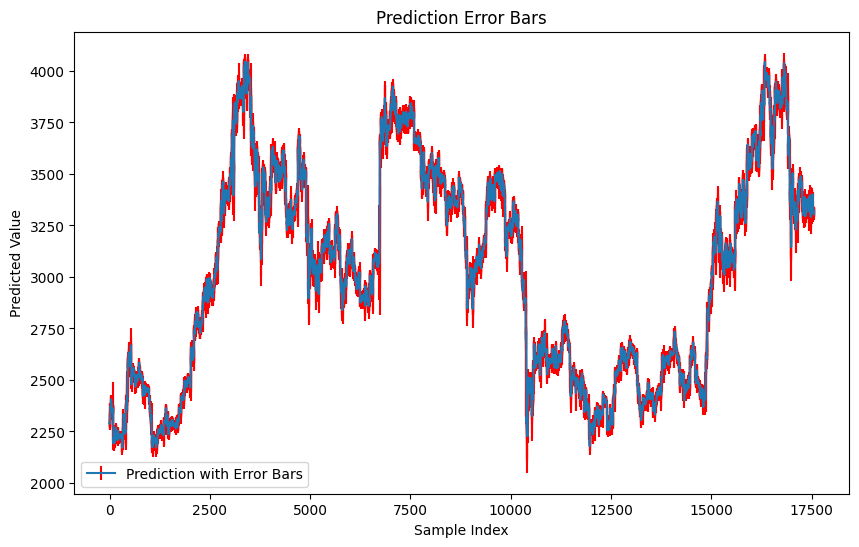

{'model': <Sequential name=sequential_164, built=True>,
 'hyperparams': {'learning_rate': 0.009041481031097066,
  'batch_size': 45,
  'epochs': 16,
  'activation': 'relu',
  'lstm_units': 94,
  'lookback': 5}}

In [71]:
getOptimalModel(SAVE_MODEL)